# NLP

In [1]:
# Initial imports
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from pathlib import Path
import re
nltk.download('vader_lexicon')
nltk.download('stopwords')
analyzer = SentimentIntensityAnalyzer()
%matplotlib inline

# Display all the text in columns
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\carli\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read in the tweets csv as a pandas DataFrame
# Convert NaNs into blanks 
file_name = 'clean_elon_tweets_vF.csv'
file_path = Path(f"../Resources/{file_name}")
tweets_data = pd.read_csv(file_path, 
                          parse_dates=True, 
                          infer_datetime_format=True).replace(np.nan, '', regex=True)


In [3]:
# Functions for cleaning the raw tweet data
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(tweets):
    # remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    # remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    return tweets


In [4]:
# Add a column for cleaned tweets in original DataFrame
tweets_data['cleaned_tweet'] = clean_tweets(tweets_data['tweet'])

# Create a list of scores
scores = []

for i in range(tweets_data['cleaned_tweet'].shape[0]):
    try:
        compound = analyzer.polarity_scores(tweets_data['cleaned_tweet'][i])["compound"]
        pos = analyzer.polarity_scores(tweets_data['cleaned_tweet'][i])["pos"]
        neu = analyzer.polarity_scores(tweets_data['cleaned_tweet'][i])["neu"]
        neg = analyzer.polarity_scores(tweets_data['cleaned_tweet'][i])["neg"]
    
        scores.append({
            "Compound": compound, 
            "Positive": pos, 
            "Negative": neg, 
            "Neutral": neu
        })
    except AttributeError:
        pass
    

In [5]:
# Create the sentiment scores DataFrame
print("Sentiment Scores")
sentiment_scores = pd.DataFrame(scores)
print(sentiment_scores.tail())

print("")

# Describe the Tweet sentiment
print("Describe Sentiment")
print(sentiment_scores.describe())

Sentiment Scores
      Compound  Positive  Negative  Neutral
2654    0.5226     0.141     0.090    0.769
2655    0.9357     0.336     0.120    0.545
2656    0.9429     0.182     0.000    0.818
2657    0.9980     0.316     0.031    0.653
2658    0.0000     0.000     0.000    0.000

Describe Sentiment
          Compound     Positive     Negative      Neutral
count  2659.000000  2659.000000  2659.000000  2659.000000
mean      0.298149     0.105044     0.029572     0.431761
std       0.448107     0.148586     0.056029     0.395964
min      -0.959400     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.617000
75%       0.784500     0.182000     0.046500     0.789000
max       0.999700     1.000000     0.756000     1.000000


In [6]:
# Join Tweets DataFrame and sentiment scores DataFrame
def join_dataframes(df, df1):
    """Join Tweets DataFrame and sentiment scores DataFrame"""
    
    df = df.join(df1)
    return df


In [7]:
tweets_data = join_dataframes(tweets_data, sentiment_scores)
tweets_data.tail(2)

,date,tweet,cleaned_tweet,Compound,Positive,Negative,Neutral
2657,2021-01-19,"@kellyreid The rate-limiting part or process in cell production is constantly changing @FrancisSuarez @CityofMiami Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but @boringcompany road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with @RonDeSantisFL about tunnels last week. If Governor &amp; Mayor want this done, we will do it. @RationalEtienne @OwenSparks_ @Tesla With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made @lexfridman @tegmark Tegmark is an exceptionally smart &amp; good human @OwenSparks_ The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. @p_ferragu Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. @tobyliiiiiiiiii @Erdayastronaut For sure @Erdayastronaut Glad you’re ok @Virgin_Orbit Congratulations! @teslaownersSV This is a good one @MrBeastYT I whistle @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai","The rate-limiting part or process in cell production is constantly changing Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with about tunnels last week. If Governor &amp; Mayor want this done, we will do it. With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made Tegmark is an exceptionally smart &amp; good human The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. For sure Glad you’re ok Congratulations! This is a good one I whistle Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai",0.998,0.316,0.031,0.653
2658,2021-01-20,,,0.000,0.000,0.000,0.000


In [8]:
# Create a list of sentiment
i = 0
Sentiment = []

while(i < len(tweets_data)):
    if ((tweets_data.iloc[i]['Compound'] > 0.5)):
        Sentiment.append('positive')
        i = i+1
    elif ((tweets_data.iloc[i]['Compound'] > -0.5) & (tweets_data.iloc[i]['Compound'] <= 0.5)):
        Sentiment.append('neutral')
        i = i+1
    elif ((tweets_data.iloc[i]['Compound'] <= -0.5)):
        Sentiment.append('negative')
        i = i+1

# Add the Sentiment column to the Tweets DataFrame
tweets_data['Sentiment'] = Sentiment
tweets_data.tail(2)


,date,tweet,cleaned_tweet,Compound,Positive,Negative,Neutral,Sentiment
2657,2021-01-19,"@kellyreid The rate-limiting part or process in cell production is constantly changing @FrancisSuarez @CityofMiami Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but @boringcompany road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with @RonDeSantisFL about tunnels last week. If Governor &amp; Mayor want this done, we will do it. @RationalEtienne @OwenSparks_ @Tesla With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made @lexfridman @tegmark Tegmark is an exceptionally smart &amp; good human @OwenSparks_ The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. @p_ferragu Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. @tobyliiiiiiiiii @Erdayastronaut For sure @Erdayastronaut Glad you’re ok @Virgin_Orbit Congratulations! @teslaownersSV This is a good one @MrBeastYT I whistle @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai","The rate-limiting part or process in cell production is constantly changing Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with about tunnels last week. If Governor &amp; Mayor want this done, we will do it. With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made Tegmark is an exceptionally smart &amp; good human The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. For sure Glad you’re ok Congratulations! This is a good one I whistle Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai",0.998,0.316,0.031,0.653,positive
2658,2021-01-20,,,0.000,0.000,0.000,0.000,neutral


# We can "uncomment" this cell once we delete the One Hot Encoder section

In [9]:
# # Get dummy variables for Sentiment column
# tweets_data['Sentiment'] = pd.get_dummies(tweets_data.Sentiment)
# tweets_data.dtypes

# Tokenizer

In [10]:
# Imports
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import string
import re

lemmatizer = WordNetLemmatizer()
sw_addon = stopwords.words('english')
sw_addon.append("u")
sw_addon.append("it'")
sw_addon.append("char")
sw_addon.append("’")
sw_addon.append("…")
sw_addon.append("”")
sw_addon.append('“')
sw_addon.append('”')
sw_addon.append('amp')
sw_addon.append('would')
sw_addon.append("n't")
sw_addon.append('wo')
sw_addon = set(sw_addon)


In [11]:
# Tokenize tweets
def tokenizer(text):
    """Tokenizes text."""   
    # Create a list of the words
    words = word_tokenize(text)
    # Convert the words to lowercase
    words = list(filter(lambda w: w.lower(), words))   
    # Remove the punctuation
    words = list(filter(lambda t: t not in punctuation, words))   
    # Remove the stopwords
    words = list(filter(lambda t: t.lower() not in sw_addon, words))   
    # Lemmatize Words into root words
    tokens = [lemmatizer.lemmatize(word) for word in words]  
    return tokens


In [12]:
# Add the tokens column to the Tweets DataFrame
tweets_data["tokens"] = tweets_data.cleaned_tweet.apply(tokenizer)
tweets_data.tail(2)


,date,tweet,cleaned_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokens
2657,2021-01-19,"@kellyreid The rate-limiting part or process in cell production is constantly changing @FrancisSuarez @CityofMiami Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but @boringcompany road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with @RonDeSantisFL about tunnels last week. If Governor &amp; Mayor want this done, we will do it. @RationalEtienne @OwenSparks_ @Tesla With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made @lexfridman @tegmark Tegmark is an exceptionally smart &amp; good human @OwenSparks_ The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. @p_ferragu Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. @tobyliiiiiiiiii @Erdayastronaut For sure @Erdayastronaut Glad you’re ok @Virgin_Orbit Congratulations! @teslaownersSV This is a good one @MrBeastYT I whistle @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai","The rate-limiting part or process in cell production is constantly changing Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with about tunnels last week. If Governor &amp; Mayor want this done, we will do it. With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made Tegmark is an exceptionally smart &amp; good human The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. For sure Glad you’re ok Congratulations! This is a good one I whistle Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai",0.998,0.316,0.031,0.653,positive,"[rate-limiting, part, process, cell, production, constantly, changing, Cars, truck, stuck, traffic, generate, megaton, toxic, gas, particulate, road, tunnel, Miami, solve, traffic, example, world, Spoke, tunnel, last, week, Governor, Mayor, want, done, giant, casting, machine, literally, trying, make, full-size, car, way, toy, car, made, Tegmark, exceptionally, smart, good, human, best, manufacturing, technology, ultra, high, volume, industry, like, food, beverage, medical, eg, syrinx, toy, Battery, cell, production, fundamental, rate-limiter, slowing, sustainable, energy, future, important, problem, Looking, question, FSD, viewed, reasonably, valuable, trade-in, sure, Glad, ok, Congratulations, good, one, whistle, Cybertruck, need, garage, awesome, Good, point, server-side, code, much, Happy, birthday, Wikipedia, glad, ...]"
2658,2021-01-20,,,

In [13]:
tweets_data['Sentiment'].value_counts()

neutral     1668
positive     929
negative      62
Name: Sentiment, dtype: int64

In [14]:
# Save the Tweets DataFrame with the tokens as a csv
save_csv=False
if save_csv==True:
    file_name="tokens_n_vader_sentiment.csv"
    output_file = Path(f"../Resources/{file_name}")
    tweets_data.to_csv(f"{output_file}")


## NGrams and Frequency Analysis

In [15]:
# Imports
from collections import Counter
from nltk import ngrams
import inspect

In [16]:
def seriesToList(s):
    """"Converts series into one list"""
    
    lst = []        
    for ele in s:  
        lst += ele 
    return lst

# Convert Tokens column in Tweets DataFrame into one list
tweets = seriesToList(tweets_data["tokens"])


In [17]:
# Create bigrams
print("Bigrams")
bigrams = ngrams(tweets, n=2)
tweets_dict = dict(Counter(bigrams).most_common(15))
tweets_bigrams = tweets_dict.items()
display(list(tweets_bigrams))

print("")
# Create unigrams
print("Unigrams")
unigrams = ngrams(tweets, n=1)
tweets_dict = dict(Counter(unigrams).most_common(15))
tweets_unigrams = tweets_dict.items()
display(list(tweets_unigrams))

Bigrams


[(('Model', '3'), 176),
 (('Falcon', '9'), 67),
 (('next', 'week'), 60),
 (('next', 'year'), 60),
 (('coming', 'soon'), 49),
 (('Falcon', 'Heavy'), 48),
 (('Model', 'X'), 47),
 (('Good', 'point'), 43),
 (('Coming', 'soon'), 41),
 (('year', 'ago'), 40),
 (('Boring', 'Company'), 38),
 (('Tesla', 'Model'), 35),
 (('Pretty', 'much'), 35),
 (('next', 'month'), 34),
 (('Tesla', 'owner'), 33)]


Unigrams


[(('Tesla',), 1058),
 (('car',), 543),
 (('Yes',), 479),
 (('year',), 398),
 (('Model',), 397),
 (('like',), 390),
 (('time',), 333),
 (('good',), 317),
 (('make',), 314),
 (('3',), 309),
 (('much',), 294),
 (('need',), 282),
 (('one',), 261),
 (('rocket',), 255),
 (('great',), 254)]

In [18]:
# Create a list of keywords
keywords = ['model 3', 'coming soon', 'next week', 
            'next year', 'falcon 9', 'falcon heavy', 
            'model x', 'next month', 'space station', 
            'sustainable energy', 'electric car', 
            'climate change', 'software update', 
            'dual motor', 'self-driving', 'giga berlin', 
            'rocket', 'engine', 'solar power', 'SpaceX', 
           ]

keywords1 = ['launch', 'production', 'starship', 
             'mars', 'time', 'rocket', 
             'soon', 'tesla', 'spacex'
            ]

# Display the keywords
display(pd.DataFrame(keywords).head(10))


,0
0,model 3
1,coming soon
2,next week
3,next year
4,falcon 9
5,falcon heavy
6,model x
7,next month
8,space station
9,sustainable energy


In [19]:
def token_count(tokens, N=15):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)


In [20]:
token_count(tweets)

[('Tesla', 1058),
 ('car', 543),
 ('Yes', 479),
 ('year', 398),
 ('Model', 397),
 ('like', 390),
 ('time', 333),
 ('good', 317),
 ('make', 314),
 ('3', 309),
 ('much', 294),
 ('need', 282),
 ('one', 261),
 ('rocket', 255),
 ('great', 254)]

---

# One Hot Encoding
May be deleted.  
Note: we need to "uncomment" the cell 9 `get_dummies` for sentiment column if we delete this section.

In [21]:
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder, StandardScaler
enc = OneHotEncoder()

In [22]:
# Fit the OneHotEncoder
class_values = tweets_data['Sentiment'].values.reshape(-1, 1)
enc.fit(class_values)

OneHotEncoder()

In [23]:
# Fetch the categories identified by the OneHotEncoder
enc.categories_

[array(['negative', 'neutral', 'positive'], dtype=object)]

In [24]:
# Encode categories
class_encoded = enc.transform(class_values).toarray()
class_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [25]:
# Create a DataFrame with the encoded class data
encoded_df = pd.DataFrame(class_encoded, columns = ["neg_enc", "neu_enc", "pos_enc"])
# Some samples of the encoded data
display(encoded_df.iloc[1:3])
display(encoded_df.iloc[100:102])

,neg_enc,neu_enc,pos_enc
1,0.0,1.0,0.0
2,0.0,1.0,0.0


,neg_enc,neu_enc,pos_enc
100,0.0,1.0,0.0
101,0.0,1.0,0.0


In [26]:
# Function to concatinate two dataframes
def concat_dataframes(df, df1):
    """Functions to concatinate two dataframes"""
    
    df = pd.concat([df, df1], axis=1)
    df = df.set_index('date')
    return df

tweets_data = concat_dataframes(tweets_data, encoded_df)
tweets_data.tail(2)

,tweet,cleaned_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokens,neg_enc,neu_enc,pos_enc
date,,,,,,,,,,,
2021-01-19,"@kellyreid The rate-limiting part or process in cell production is constantly changing @FrancisSuarez @CityofMiami Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but @boringcompany road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with @RonDeSantisFL about tunnels last week. If Governor &amp; Mayor want this done, we will do it. @RationalEtienne @OwenSparks_ @Tesla With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made @lexfridman @tegmark Tegmark is an exceptionally smart &amp; good human @OwenSparks_ The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. @p_ferragu Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. @tobyliiiiiiiiii @Erdayastronaut For sure @Erdayastronaut Glad you’re ok @Virgin_Orbit Congratulations! @teslaownersSV This is a good one @MrBeastYT I whistle @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai","The rate-limiting part or process in cell production is constantly changing Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with about tunnels last week. If Governor &amp; Mayor want this done, we will do it. With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made Tegmark is an exceptionally smart &amp; good human The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. For sure Glad you’re ok Congratulations! This is a good one I whistle Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai",0.998,0.316,0.031,0.653,positive,"[rate-limiting, part, process, cell, production, constantly, changing, Cars, truck, stuck, traffic, generate, megaton, toxic, gas, particulate, road, tunnel, Miami, solve, traffic, example, world, Spoke, tunnel, last, week, Governor, Mayor, want, done, giant, casting, machine, literally, trying, make, full-size, car, way, toy, car, made, Tegmark, exceptionally, smart, good, human, best, manufacturing, technology, ultra, high, volume, industry, like, food, beverage, medical, eg, syrinx, toy, Battery, cell, production, fundamental, rate-limiter, slowing, sustainable, energy, future, important, problem, Looking, question, FSD, viewed, reasonably, valuable, trade-in, sure, Glad, ok, Congratulations, good, one, whistle, Cybertruck, need, garage, awesome, Good, point, server-side, code, much, Happy, birthday, Wikipedia, 

In [27]:
# Get dummy variables for Sentiment column
tweets_data['Sentiment'] = pd.get_dummies(tweets_data.Sentiment)
tweets_data.dtypes

tweet             object
cleaned_tweet     object
Compound         float64
Positive         float64
Negative         float64
Neutral          float64
Sentiment          uint8
tokens            object
neg_enc          float64
neu_enc          float64
pos_enc          float64
dtype: object

In [28]:
# Function to rearrange columns in a DataFrame

def arrange_columns(df): 
    """Arrange columns in a DataFrame"""
    
    cols = df.columns.tolist()
    cols = cols[:6] + cols[-3:] + cols[6:8]
    df = df[cols]
    return df

tweets_data = arrange_columns(tweets_data)
tweets_data.tail(2)

,tweet,cleaned_tweet,Compound,Positive,Negative,Neutral,neg_enc,neu_enc,pos_enc,Sentiment,tokens
date,,,,,,,,,,,
2021-01-19,"@kellyreid The rate-limiting part or process in cell production is constantly changing @FrancisSuarez @CityofMiami Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but @boringcompany road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with @RonDeSantisFL about tunnels last week. If Governor &amp; Mayor want this done, we will do it. @RationalEtienne @OwenSparks_ @Tesla With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made @lexfridman @tegmark Tegmark is an exceptionally smart &amp; good human @OwenSparks_ The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. @p_ferragu Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. @tobyliiiiiiiiii @Erdayastronaut For sure @Erdayastronaut Glad you’re ok @Virgin_Orbit Congratulations! @teslaownersSV This is a good one @MrBeastYT I whistle @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai @DMC_Ryan @C_R_H_M @Tesla Cybertruck doesn’t need a garage @DMC_Ryan @Tesla It will be awesome @owenshift Good point @signalapp Your server-side code is doing too much @Wikipedia Happy birthday Wikipedia! So glad you exist. @TheOnion Guess you been watching Cobra Kai","The rate-limiting part or process in cell production is constantly changing Cars &amp; trucks stuck in traffic generate megatons of toxic gases &amp; particulate, but road tunnels under Miami would solve traffic &amp; be an example to the world. Spoke with about tunnels last week. If Governor &amp; Mayor want this done, we will do it. With our giant casting machines, we are literally trying to make full-size cars in the same way that toy cars are made Tegmark is an exceptionally smart &amp; good human The best manufacturing technology is in ultra high volume industries, like food &amp; beverage, some medical (eg syringes) &amp; toys Battery cell production is the fundamental rate-limiter slowing down a sustainable energy future. Very important problem. Looking into this. No question that FSD should be viewed as reasonably valuable when doing a trade-in. For sure Glad you’re ok Congratulations! This is a good one I whistle Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai Cybertruck doesn’t need a garage It will be awesome Good point Your server-side code is doing too much Happy birthday Wikipedia! So glad you exist. Guess you been watching Cobra Kai",0.998,0.316,0.031,0.653,0.0,0.0,1.0,0,"[rate-limiting, part, process, cell, production, constantly, changing, Cars, truck, stuck, traffic, generate, megaton, toxic, gas, particulate, road, tunnel, Miami, solve, traffic, example, world, Spoke, tunnel, last, week, Governor, Mayor, want, done, giant, casting, machine, literally, trying, make, full-size, car, way, toy, car, made, Tegmark, exceptionally, smart, good, human, best, manufacturing, technology, ultra, high, volume, industry, like, food, beverage, medical, eg, syrinx, toy, Battery, cell, production, fundamental, rate-limiter, slowing, sustainable, energy, future, important, problem, Looking, question, FSD, viewed, reasonably, valuable, trade-in, sure, Glad, ok, Congratulations, good, one, whistle, Cybertruck, need, garage, awesome, Good, point, server-side, code, much, Happy, birthday, Wikipe

In [29]:
file_name="tokens_n_vader_sentiment.csv"

output_file = Path(f"../Resources/{file_name}")
tweets_data.to_csv(f"{output_file}")


In [30]:
tweets_data['neu_enc'].value_counts()

1.0    1668
0.0     991
Name: neu_enc, dtype: int64

---
# Word Clouds

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

In [32]:
keywords = ['model_3', 'model_x', 'coming_soon', 'next_week',
            'next_year', 'sustainable_energy',  'climate_change',
            'giga_berlin', 'falcon_9', 'falcon_heavy', 'next_month', 
            'space_station', 'electric_car', 'software_update', 
            'dual_motor', 'self_driving', 'rocket', 'engine', 
            'solar_power', 'SpaceX', 'launch', 'production', 
            'starship', 'mars', 'time', 'soon', 'tesla'
           ]

keywords1 = ['launch', 'production', 'starship', 
             'mars', 'time', 'rocket', 
             'soon', 'tesla', 'spacex'
            ]

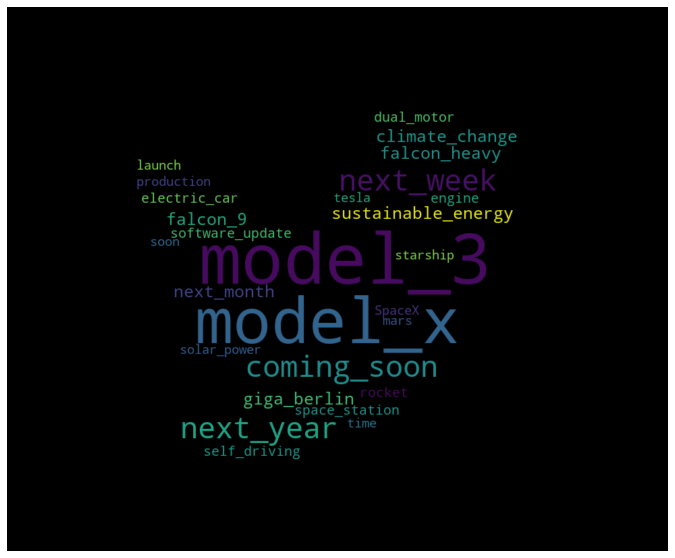

In [33]:
# Load the image
wave_mask = np.array(Image.open("twitter.jpg"))

# Generate the Tweet word cloud
keywords = ' '.join(keywords)
wc = WordCloud(mask=wave_mask).generate(keywords)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()